In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.qc import *
from src.energy_calculation import *
from src.utils import write_to_csv 
sns.set_theme(font_scale=1.5)
from tqdm import tqdm
import tikzplotlib
from scipy.optimize import minimize
import pandas as pd

In [2]:
qubit = Qubit(1)
X, Z, I = qubit.X, qubit.Z, qubit.I
ket0 = np.array([1, 0])
ket1 = np.array([0, 1])

def Hamiltonian(lmb):    
    Hx = 2.0 
    Hz = 3.0
    H0Energiesnoninteracting = [0.0, 2.5, 6.5, 7.0]
    
    HI = Hz*np.kron(Z, Z) + Hx*np.kron(X, X)
    H0 = np.diag(H0Energiesnoninteracting)
    H = H0 + lmb*HI
    return H


def trace_out(state, index):
    density = np.outer(state, np.conj(state))
    if index == 0:
        op0 = np.kron(ket0, I)
        op1 = np.kron(ket1, I)
    elif index == 1:
        op0 = np.kron(I, ket0)
        op1 = np.kron(I, ket1)
    return op0 @ density @ op0.T.conj() + op1 @ density @ op1.T.conj() 

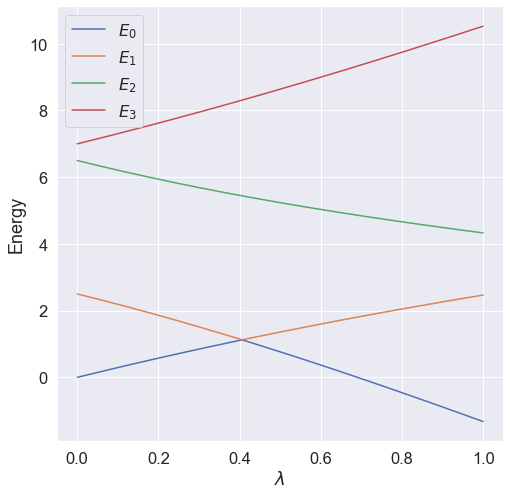

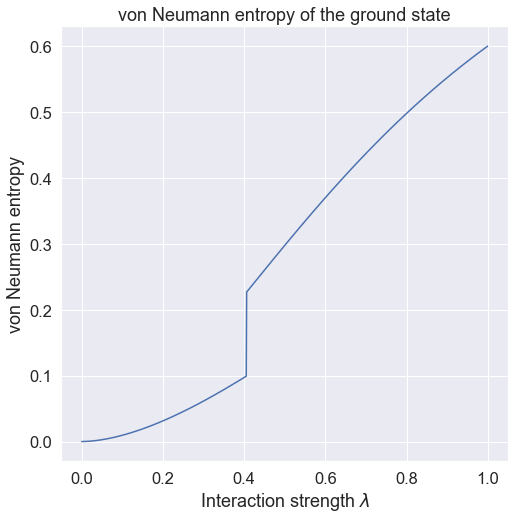

In [8]:
lmbvalues_ana = np.arange(0, 1, 0.001)
eigvals_ana = np.zeros((len(lmbvalues_ana), 4))
entropy = np.zeros((len(lmbvalues_ana), 4))
for index, lmb in enumerate(lmbvalues_ana):
    H = Hamiltonian(lmb)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]
    for i in range(4):
        sub_density = trace_out(eigvecs[:, i], 0) # trace out qubit 0 from the ground state
        lmb_density = np.linalg.eigvalsh(sub_density)
        lmb_density = np.ma.masked_equal(lmb_density, 0).compressed() # remove zeros to avoid log(0)
        entropy[index, i] = -np.sum(lmb_density*np.log2(lmb_density))

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(4):
    axs.plot(lmbvalues_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
axs.legend()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(1):
    axs.plot(lmbvalues_ana, entropy[:, i], label=f'$H_{i}$')
axs.set_xlabel(r'Interaction strength $\lambda$')
axs.set_ylabel('von Neumann entropy')
axs.set_title('von Neumann entropy of the ground state')
tikzplotlib.clean_figure()
tikzplotlib.save(
    f'../plots/entropy.tex',
    extra_axis_parameters=[
        'title style={align=center}',
        'xmajorticks=true',
        'ymajorticks=true',
        'mark options={mark size=1.4pt, line width=1.5pt}',
        ],
        strict=True,
    )
plt.show()


In [4]:
qubit = Qubit(2)
Hx = 2.0 
Hz = 3.0
eps00, eps01, eps10, eps11 = np.array([0.0, 2.5, 6.5, 7.0])
A = (eps00 + eps01 + eps10 + eps11) / 4.0
B = (eps00 - eps01 + eps10 - eps11) / 4.0
C = (eps00 + eps01 - eps10 - eps11) / 4.0
D = (eps00 - eps01 - eps10 + eps11) / 4.0

qb = Qubit(2)
I, Z, X, H, SWAP, CNOT10 = qb.I, qb.Z, qb.X, qb.H, qb.SWAP, qb.CNOT10
II = np.kron(I, I)
ZI = np.kron(Z, I)
unitaries  = [SWAP, II, ZI@CNOT10, CNOT10@(np.kron(H, H))]    
const_term = A

In [5]:
number_shots = 2**(14)
lmbvalues = np.linspace(0.0, 1.0, 10)
min_energy = np.zeros(len(lmbvalues))
for index, lmb in enumerate(tqdm(lmbvalues)):
    constants = [B, C, D + lmb*Hz, lmb*Hx]
    const_term = (A)
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    args = (number_shots, unitaries, prepare_state_2D, constants, const_term)
    res = minimize(get_energy, angles_start, args = args, method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy[index] = res.fun

write_to_csv(lmbvalues, min_energy, header='lmb,energy', filename='../data/2D-simple-H')

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


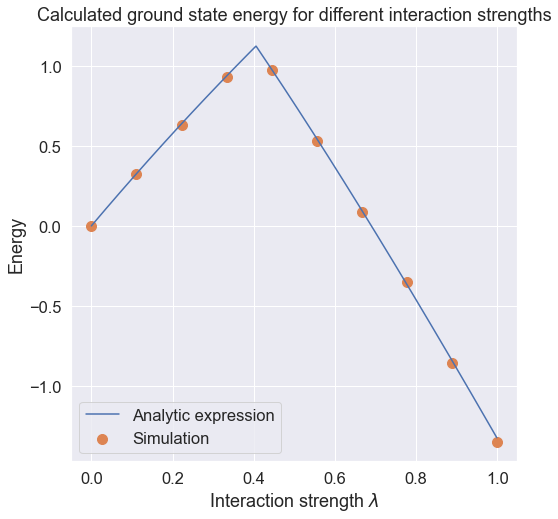

In [7]:
df = pd.read_csv('../data/2D-simple-H.csv')
lmbvalues = df['lmb'].to_numpy()
min_energy = df['energy'].to_numpy()

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(1):
    axs.plot(lmbvalues_ana, eigvals_ana[:, i], label=f'Analytic expression')
axs.set_xlabel(r'Interaction strength $\lambda$')
# axs.scatter(lmbvalues, min_energy, label='VQE Energy GD', marker='o')
# axs.scatter(lmbvalues_qiskit, min_energy_qiskit, label='VQE Energy Qiskit', marker='o')
axs.scatter(lmbvalues, min_energy, label='Simulation', marker='o', color = '#dd8452', s= 100)
axs.set_title('Calculated ground state energy for different interaction strengths')
axs.set_ylabel('Energy')
axs.legend(loc = 'lower left')
tikzplotlib.clean_figure()
tikzplotlib.save(
    f'../plots/2D-simple-H.tex',
    extra_axis_parameters=[
        'title style={align=center}',
        'xmajorticks=true',
        'ymajorticks=true',
        'mark options={mark size=1.4pt, line width=1.5pt}',
        ],
        strict=True,
    )
plt.show()